In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import pickle

In [68]:
#input WGBS file from cancer tissue
file = 'MALY_prevBase_TP53cds.tsv'
df = pd.read_csv(file, sep='\t')
locations = []
for chrom, start, stop in zip(list(df['chromosome']), list(df['start']), list(df['stop'])):
    locations.append((str(chrom), int(start), int(stop)))
df['location'] = locations
grouped = df.groupby('location')
groupby = grouped.agg({'methylation_ratio': [np.mean, np.std], 'prev_base': 'max'})
groupby.reset_index(inplace=True)
groupby.columns = groupby.columns.droplevel(0)
# groupby.to_csv(file[:-4] + '.tsv', sep='\t')


In [69]:
y = groupby['mean'] #mean ratio from cancer
y_err = groupby['std'] #standard deviation from cancer samples
x = np.array([i for i in range(1, groupby.shape[0] + 1)]) # ticks for each CpG in coding region
x_labels = list(set([i[1] for i in df.location])) #coordinate of cytosine as labels
# x_labels = [i + 'CG' for i in groupby['max']]
# print (x_labels)
x_labels.sort()
# print (x_labels)

In [70]:
df


,chromosome,start,stop,id,methylation_ratio,prev_base,location
0,chr17,7572972,7572973,4118819_GCB,0.91,G,"(chr17, 7572972, 7572973)"
1,chr17,7572972,7572973,4122131_GCB,0.94,G,"(chr17, 7572972, 7572973)"
2,chr17,7572972,7572973,4160735_GCB,0.92,G,"(chr17, 7572972, 7572973)"
3,chr17,7572972,7572973,4174884_GCB,0.96,G,"(chr17, 7572972, 7572973)"
4,chr17,7572972,7572973,tumor_4105105,0.95,G,"(chr17, 7572972, 7572973)"
5,chr17,7572972,7572973,tumor_4112512,1.00,G,"(chr17, 7572972, 7572973)"
6,chr17,7572972,7572973,tumor_4119027,0.93,G,"(chr17, 7572972, 7572973)"
7,chr17,7572972,7572973,tumor_4121361,0.88,G,"(chr17, 7572972, 7572973)"
8,chr17,7572972,7572973,tumor_4125240,0.90,G,"(chr17, 7572972, 7572973)"
9,chr17,7572972,7572973,tumor_4133511,0.86,G,"(chr17, 7572972, 7572973)"


In [71]:
locs = list(groupby.iloc[:, 0])
locs == sorted(locs)

True

In [72]:
#input WGBS file from normal tissue
df2 = pd.read_csv('TP53_normal_cds_CpGs.tsv', sep='\t')
c = list(df2.start)
c = [i for i in c if i in x_labels]
c.sort() # now normal and cancer coordinates are matching
y2 = [] #methylation ratio from normal tissue 
for e in c:
    r = df2['methylation_ratio'].where(df2['start'] == e)
    # r is a series with all Nan's except for the value we want
    for a in r:
        if not np.isnan(a):
            y2.append(a)

In [73]:
#add mutated sites to profile
mutation_dict = pickle.load(open('MALY-DE_mutation_dict.pickle', 'rb'))
mutations = [] #coordinate of mutated site
mut_ratios = [] #metthylation ratio of mutated site if available
frequencies = [] #frequency of mutation(# of samples it occurred in)
for loc, sample, ratio in zip(df.location, df.id, df.methylation_ratio):
#     loc = (str(chrom), int(start), int(stop))
    if loc in mutation_dict and loc[1] not in mutations:
        if sample in mutation_dict[loc]:
            mut_ratios.append(ratio)
        else:
            mut_ratios.append(1.3)
        
        mutations.append(loc[1])
        frequencies.append(len(mutation_dict[loc]))
               
# mut_ratios = [0.0 for _ in mutations]
print (np.array(list(mutations)))
print (mut_ratios)

[7577119 7577537 7577547]
[1.3, 1.3, 1.3]


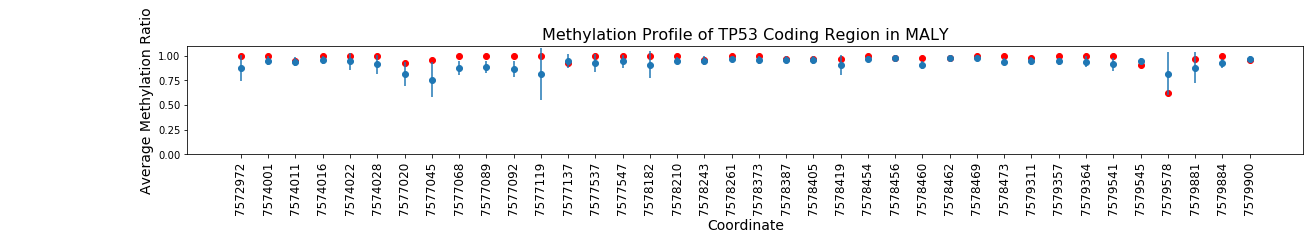

In [74]:
%matplotlib inline
fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation='vertical', fontsize=12)
ax.set_ylim((0.0, 1.1))
ax.errorbar(x, y, yerr=y_err, fmt='o')
ax.set_xlabel('Coordinate', fontsize=14)
ax.set_ylabel('Average Methylation Ratio', fontsize=14)
ax.scatter(x, y2, color='red')
# ax.scatter(np.array(list(mutations)), np.array(mut_ratios), color='green')
for u, v, f in zip(mutations, mut_ratios, frequencies):
    ax.annotate(str(f), xy=(x_labels.index(u) + 1, v), arrowprops=dict(facecolor='black', shrink=0.05),)
ax.set_title('Methylation Profile of TP53 Coding Region in MALY', fontsize=16)

In [75]:
print (mut_ratios)

[1.3, 1.3, 1.3]


In [76]:
print (mutations)

[7577119, 7577537, 7577547]


In [77]:
print (frequencies)

[1, 1, 1]


In [78]:
print (mutation_dict[('chr17', 7577547, 7577547 + 1)])

['tumor_4112512']
